### Main code for implementation and training

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

class PoissonMNISTDataset(Dataset):
    def __init__(self, images, labels, time_steps=100):
        self.images = images  
        self.labels = labels
        self.time_steps = time_steps

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  
        label = self.labels[idx]

        # On-the-fly Poisson encoding: (784, time_steps)
        spike_train = (np.random.rand(784, self.time_steps) < image[:, None]).astype(np.uint8)
        
        return torch.tensor(spike_train, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

def poisson_encode(images, time_steps=100):
    N, pixels = images.shape
    spikes = np.random.rand(N, pixels, time_steps) < images[..., np.newaxis]
    #Creates a spike(1) if the random integer is less than the pixel intensity
    return spikes.astype(np.uint8)

def plot_spike_train(spike_train, label, idx):
    """
    Raster plot for one image's spike train (784 x T)
    """
    plt.figure(figsize=(10, 5))
    for neuron_id in range(784):
        spike_times = np.where(spike_train[neuron_id])[0]
        plt.scatter(spike_times, [neuron_id]*len(spike_times), s=1, color='black')
    plt.title(f"Digit: {label}  (Sample #{idx})")
    plt.xlabel("Time step")
    plt.ylabel("Pixel index")
    plt.xlim(0, time_steps)
    plt.ylim(0, 784)
    plt.tight_layout()
    plt.show()

class SurrogateSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, threshold=1.0):
        ctx.save_for_backward(input)
        return (input >= threshold).float()

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        return grad_input * torch.sigmoid(input * 5) * (1 - torch.sigmoid(input * 5)) * 5, None

class LIFLayer(nn.Module):
    def __init__(self, input_size, output_size, threshold=1.0, decay=0.25):
        super().__init__()
        self.fc = nn.Linear(input_size, output_size, bias=False)
        self.threshold = threshold
        self.decay = decay

    def forward(self, x, state):
        # x: (batch, input_size)
        # state: membrane potential
        mem = state * self.decay + self.fc(x)
        spikes = SurrogateSpike.apply(mem, self.threshold)
        mem = mem * (1 - spikes)  # reset after spike
        return spikes, mem

class SNNModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.lif1 = LIFLayer(784, 256)
        self.lif2 = LIFLayer(256, 10)
    
    def forward(self, x):
        batch_size, input_size, time_steps=x.shape
        mem1 = torch.zeros(batch_size, 256, device=x.device)
        mem2 = torch.zeros(batch_size, 10, device=x.device)
        output_spikes = torch.zeros(batch_size, 10, device=x.device)

        for t in range(time_steps):
            input_t=x[:,:,t]
            spk1, mem1 = self.lif1(input_t, mem1)
            spk2, mem2 = self.lif2(spk1, mem2)
            output_spikes += spk2
        
        return output_spikes / time_steps

# Load the CSVs
train_df = pd.read_csv("./mnist_train.csv")  
test_df = pd.read_csv("./mnist_test.csv")    

# Separate features and labels
train_labels = train_df.iloc[:, 0].to_numpy()
train_images = train_df.iloc[:, 1:].to_numpy()

# Normalize pixel values to [0, 1]
train_images = train_images.astype(np.float32) / 255.0
test_images = test_df.to_numpy().astype(np.float32) / 255.0

time_steps = 100
train_dataset = PoissonMNISTDataset(train_images, train_labels, time_steps)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

model = SNNModel(784, 10).to("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(5):
    model.train()
    total_correct = 0
    total_samples = 0
    total_loss = 0.0

    for batch_spikes, batch_labels in train_loader:
        batch_spikes = batch_spikes.to(device)
        batch_labels = batch_labels.to(device)

        output = model(batch_spikes)  
        loss = loss_fn(output, batch_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accuracy calculation
        preds = torch.argmax(output, dim=1)
        total_correct += (preds == batch_labels).sum().item()
        total_samples += batch_labels.size(0)
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples * 100
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}%")


Epoch 1 | Loss: 1.8048 | Accuracy: 78.33%
Epoch 2 | Loss: 1.6069 | Accuracy: 90.95%
Epoch 3 | Loss: 1.5603 | Accuracy: 93.27%
Epoch 4 | Loss: 1.5346 | Accuracy: 94.69%
Epoch 5 | Loss: 1.5195 | Accuracy: 95.75%


### Saving the model

In [8]:
import pickle

# Save the trained model's weights
with open("snn_model_weights.pkl", "wb") as f:
    pickle.dump(model.state_dict(), f)


### Evaluting on the test dataset

In [9]:
# Reconstruct the model structure
model = SNNModel(784, 10).to(device)

# Load the saved weights
with open("snn_model_weights.pkl", "rb") as f:
    state_dict = pickle.load(f)
model.load_state_dict(state_dict)
model.eval()  # Set to evaluation mode

# Reuse the same training dataset and loader
train_dataset = PoissonMNISTDataset(train_images, train_labels, time_steps=100)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

# Evaluate accuracy on training data
total_correct = 0
total_samples = 0

with torch.no_grad():  # No gradient needed for evaluation
    for batch_spikes, batch_labels in train_loader:
        batch_spikes = batch_spikes.to(device)
        batch_labels = batch_labels.to(device)

        output = model(batch_spikes)
        preds = torch.argmax(output, dim=1)
        total_correct += (preds == batch_labels).sum().item()
        total_samples += batch_labels.size(0)

train_accuracy = total_correct / total_samples * 100
print(f" Training Accuracy from saved model: {train_accuracy:.2f}%")


 Training Accuracy from saved model: 96.34%


### Plotting the training accuracies and losses

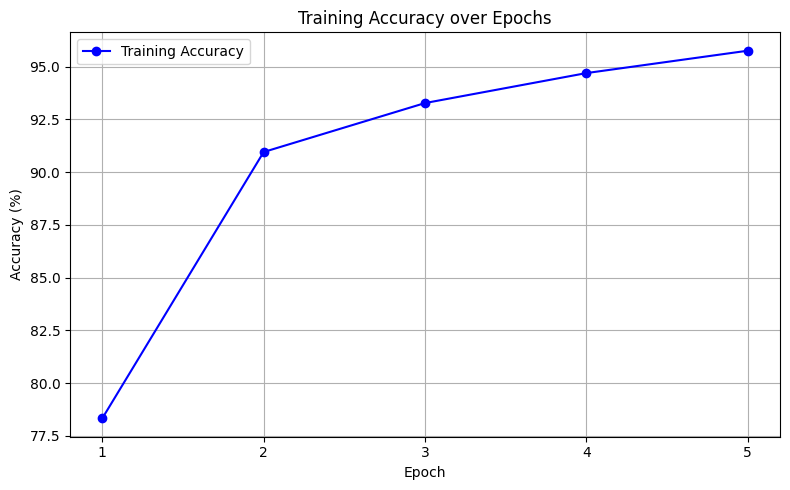

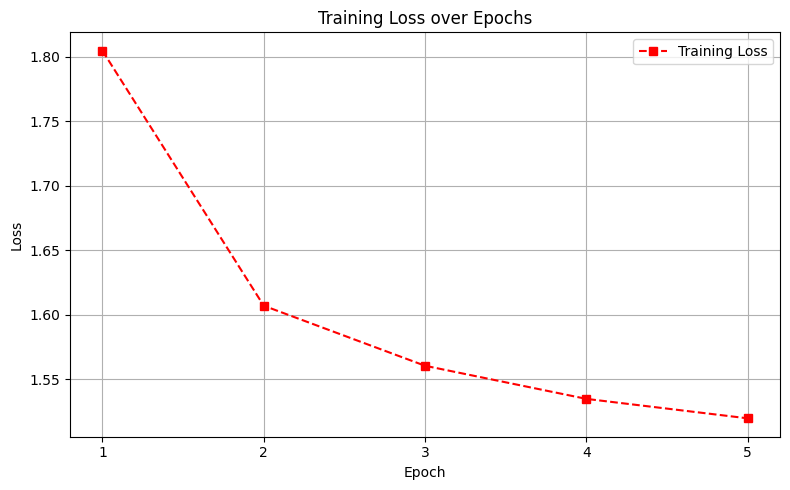

In [10]:
import matplotlib.pyplot as plt

# Accuracy and loss values from your training log
train_accuracies = [78.33, 90.95, 93.27, 94.69, 95.75]
train_losses = [1.8048, 1.6069, 1.5603, 1.5346, 1.5195]
epochs = range(1, 6)

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracies, marker='o', linestyle='-', color='blue', label='Training Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy over Epochs")
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, marker='s', linestyle='--', color='red', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
